In [1]:
import numpy as np
import pandas as pd


def raster(event_name,cellid,event_times,rasterfs,PreEndTime=200,PostBegTime=500):
    # spike_dict : spikes of a hole recording
    # unitidx : unit's spikes we want to look at
    # stim_dict : stimuli, used for the names of the events
    # eventidx : idx of event we want to look at
    # rasterfs : spike frequency
    
    binlen=1.0/rasterfs
    h=np.array([])
    ff = (event_times['name']==event_name)
    ## pull out each epoch from the spike times, generate a raster of spike rate
    for i,d in event_times.loc[ff].iterrows():
        #print("{0}-{1}".format(d['start'],d['end']))
        edges=np.arange(d['start']+PreEndTime/rasterfs,d['start']+PostBegTime/rasterfs+binlen,binlen)
        #edges=np.arange(d['start'],d['end']+binlen,binlen)
        #if i==0:
        #print(d)
        #print(edges) #d['end']-d['start']+binlen)
        #print(len(edges))
        th,e=np.histogram(spike_dict[cellid],edges)

        #print("{0}-{1}: {2}".format(edges[0],edges[1],sum((spike_dict[cellid]>edges[0]) & (spike_dict[cellid]<edges[1]))))
        th=np.reshape(th,[1,-1])
        if h.size==0:
            # lazy hack: intialize the raster matrix without knowing how many bins it will require
            h=th
        else:
            # concatenate this repetition, making sure binned length matches
            if th.shape[1]<h.shape[1]:
                h=np.concatenate((h,np.zeros([1,h.shape[1]])),axis=0)
                h[-1,:]=np.nan
                h[-1,:th.shape[1]]=th
            else:
                h=np.concatenate((h,th[:,:h.shape[1]]),axis=0)
                
    m = np.nanmean(h,axis=0)
    return h,m

def getTrainTestTimes(event_times,trainNb,testNb):
    # event_times : timings of events 
    # trainNb : number of stimuli presented for the trains
    # testNb : number of stimuli presented for the tests
    
    wavEvents = event_times[event_times['name'].str.contains('.wav')]
    occurences =  wavEvents['name'].value_counts(sort=True)

    Train_names = list(occurences[occurences==trainNb].index)
    Test_names = list(occurences[occurences==testNb].index)
    if Train_names == [] or Test_names == [] :
        raise ValueError('wrong trainNb or testNb')        
    
    Train_times = pd.DataFrame(columns={'name','start','end'})
    Train_times = Train_times[['name','start','end']] #Order the columns
    Test_times = Train_times.copy()

    #Get stimuli onset and offset times for trains
    trial_indexs = event_times['name'][event_times['name']=='TRIAL'].index
    idx1 = 0; idx2 = 0;
    for trial_idx in trial_indexs:
        name = event_times.iloc[trial_idx+1]['name']
        if name in Train_names :
            Train_times.at[idx1,'name'] = name
            Train_times.at[idx1,'start'] = event_times.iloc[trial_idx+3]['end']
            Train_times.at[idx1,'end'] = event_times.iloc[trial_idx+4]['start']
            idx1 +=1
        elif name in Test_names :
            Test_times.at[idx2,'name'] = name
            Test_times.at[idx2,'start'] = event_times.iloc[trial_idx+3]['end']
            Test_times.at[idx2,'end'] = event_times.iloc[trial_idx+4]['start']
            idx2 +=1
        else : 
            raise ValueError('Neither a Test nor a Train stimuli name')

    #Train_times = Train_times.sort_values('name')
    #Test_times = Test_times.sort_values('name')

    return Train_times,Test_times

In [2]:
import os
import io
import re
import numpy as np
import scipy.io
#import nems.recording as Recording
import pandas as pd
import matplotlib.pyplot as plt

import nems.utilities as nu
import nems.db as nd
import nems.utilities.baphy
#from toolbox_fun import raster
#import toolbox_fun

parmfilepath='/auto/data/daq/Tartufo/TAR010/TAR010c16_p_NAT.m'

options={'rasterfs': 100, 'includeprestim': True, 'stimfmt': 'ozgf', 'chancount': 18, 'cellid': 'all', 'pupil': True}
event_times, spike_dict, stim_dict, state_dict = nu.baphy.baphy_load_recording(parmfilepath,options)

Cached stim: /auto/data/tmp/tstim/NaturalSounds-2-0.5-3-1-White______-100-0-3__8-65dB-ozgf-fs100-ch18-incps1.mat
Spike file: /auto/data/daq/Tartufo/TAR010/sorted/TAR010c16_p_NAT.spk.mat
rounding Trial offset spike times to even number of rasterfs bins
342 trials totaling 2076.12 sec
Creating trial events
Creating trial outcome events
Removing post-response stimuli
Keeping 2394/2394 events that precede responses


In [ ]:
## Try out raster

unitidx=6 # which unit
stimevents=list(stim_dict.keys())
cellids=list(spike_dict.keys())



for eventidx in range(90):
    #for unitidx in range(55):
    event_name=stimevents[eventidx]
    cellid=cellids[unitidx]

    plt.figure()
    plt.imshow(stim_dict[event_name][:,200:500],origin='lower',aspect='auto')
    plt.title("stimuli {} - neuron {} ".format(eventidx,unitidx))


    h,m = raster(event_name,cellid,event_times,options['rasterfs'],PreEndTime,PostBegTime)
    plt.figure()
    plt.plot(m)
        

if 0:
    event_name=stimevents[eventidx]
    cellid=cellids[unitidx]
    #print(stim_dict[event_name].shape)

    plt.figure()
    plt.imshow(stim_dict[event_name][:,200:500],origin='lower',aspect='auto')
    plt.title("stim {0}".format(event_name))

    h,m = raster(event_name,cellid,event_times,options['rasterfs'],PreEndTime,PostBegTime)


    plt.figure()
    plt.plot(m)

In [105]:
#### KERAS 1D CONV MODEL
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Conv1D,Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.constraints import non_neg
import keras.initializers
import keras.optimizers

# fix random seed for reproducibility
np.random.seed(7)

# Segregate Train and Tests
Train_times,Test_times = getTrainTestTimes(event_times,3,24)

# Compute on a specific cell --> TODO : for all
cellidx = 15
cellid = list(spike_dict.keys())[cellidx] 

#_________________Training input (X)_______________________#
stim_shape = np.shape(stim_dict[list(stim_dict.keys())[0]])
nbTrains = len(set(Train_times['name']))

# sound_time : from end of prestimsilence and beg of poststimsilence
PreStimidx = list(event_times['name']).index('PreStimSilence')
Endidx = event_times.columns.get_loc('end')
fs_spectro = 100 # to convert in samples
PostBegTime = int(event_times.iloc[PreStimidx+1,Endidx-1]*fs_spectro)
PreEndTime = int(event_times.iloc[PreStimidx,Endidx]*fs_spectro)
sound_time = PostBegTime - PreEndTime

X = np.zeros( (nbTrains,sound_time,stim_shape[0]) )

for idx,event_name in enumerate(set(Train_times['name'])):
    X[idx,:,:] = np.transpose(stim_dict[event_name][:,PreEndTime:PostBegTime]) 

X = X/X.max()

#_________________Training output (Y)_______________________#
Y = np.zeros( (nbTrains,sound_time,1) )


for idx,event_name in enumerate(set(Train_times['name'])):
    h,m = raster(event_name,cellid,event_times,options['rasterfs'],PreEndTime,PostBegTime)
    Y[idx,:,0] = np.transpose(m[0:np.size(Y,1)])
    
Y = Y/Y.max()

#_________________Test output (Z)_______________________#
nbTests = len(set(Test_times['name']))
Z = np.zeros( (nbTests, sound_time,1) )

for idx,event_name in enumerate(set(Test_times['name'])):
    h,m = raster(event_name,cellid,event_times,options['rasterfs'],PreEndTime,PostBegTime)
    Z[idx,:,0] = np.transpose(m[0:np.size(Z,1)])
    
#Z.shape

# create model
time_window = 10

model = Sequential()
layer = Conv1D(input_shape=np.shape(X)[1:3],filters=1,kernel_size=time_window,strides=1,
            padding='causal', dilation_rate=1,use_bias=True,
            bias_initializer='random_uniform', kernel_constraint=non_neg())

layer.kernel_initializer = keras.initializers.RandomUniform(minval=0, maxval=0.05, seed=None)
#layer.kernel_initializer = 'random_uniform'
model.add(layer)

# Compile model
lr = 0.005
loss = 'mse'
sgd = keras.optimizers.SGD(lr=lr)
#model.compile(loss='binary_crossentropy', optimizer='sgd')
model.compile(loss = loss, optimizer=sgd)

# Fit the model
#history = model.fit(X, Y, epochs=800, batch_size=10)
epochs = 2000
batch_size = 'no'

if batch_size == 'no':
    history = model.fit(X, Y, epochs=epochs)
else :
    history = model.fit(X,Y,epochs=epochs, batch_size=batch_size)

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores*100))

predicted = model.predict(X)

Epoch 1/2000
90/90 [==============================] - 0s 1ms/step - loss: 0.0182
Epoch 2/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0179
Epoch 3/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0176
Epoch 4/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0173
Epoch 5/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0170
Epoch 6/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0167
Epoch 7/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0165
Epoch 8/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0163
Epoch 9/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0160
Epoch 10/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0158
Epoch 11/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0157
Epoch 12/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0155
Epoch 13/2000


90/90 [==============================] - 0s 61us/step - loss: 0.0116
Epoch 100/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0116
Epoch 101/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0116
Epoch 102/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0115
Epoch 103/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0115
Epoch 104/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0115
Epoch 105/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0115
Epoch 106/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0115
Epoch 107/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0115
Epoch 108/2000
90/90 [==============================] - 0s 73us/step - loss: 0.0115
Epoch 109/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0114
Epoch 110/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0114
Epoch 1

90/90 [==============================] - 0s 58us/step - loss: 0.0105
Epoch 197/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0105
Epoch 198/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0105
Epoch 199/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0105
Epoch 200/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0105
Epoch 201/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0105
Epoch 202/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0104
Epoch 203/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0104
Epoch 204/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0104
Epoch 205/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0104
Epoch 206/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0104
Epoch 207/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0104
Epoch 2

90/90 [==============================] - 0s 59us/step - loss: 0.0098
Epoch 294/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0098
Epoch 295/2000
90/90 [==============================] - 0s 117us/step - loss: 0.0098
Epoch 296/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0098
Epoch 297/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0098
Epoch 298/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0098
Epoch 299/2000
90/90 [==============================] - 0s 72us/step - loss: 0.0098
Epoch 300/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0098
Epoch 301/2000
90/90 [==============================] - 0s 72us/step - loss: 0.0098
Epoch 302/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0098
Epoch 303/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0098
Epoch 304/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0097
Epoch 

90/90 [==============================] - 0s 61us/step - loss: 0.0094
Epoch 391/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0094
Epoch 392/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0094
Epoch 393/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0094
Epoch 394/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0094
Epoch 395/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0093
Epoch 396/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0093
Epoch 397/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0093
Epoch 398/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0093
Epoch 399/2000
90/90 [==============================] - 0s 71us/step - loss: 0.0093
Epoch 400/2000
90/90 [==============================] - 0s 77us/step - loss: 0.0093
Epoch 401/2000
90/90 [==============================] - 0s 76us/step - loss: 0.0093
Epoch 4

90/90 [==============================] - 0s 63us/step - loss: 0.0091
Epoch 488/2000
90/90 [==============================] - 0s 65us/step - loss: 0.0091
Epoch 489/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0091
Epoch 490/2000
90/90 [==============================] - 0s 73us/step - loss: 0.0091
Epoch 491/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0091
Epoch 492/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0091
Epoch 493/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0091
Epoch 494/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0091
Epoch 495/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0091
Epoch 496/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0090
Epoch 497/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0090
Epoch 498/2000
90/90 [==============================] - 0s 115us/step - loss: 0.0090
Epoch 

90/90 [==============================] - 0s 60us/step - loss: 0.0089
Epoch 585/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0089
Epoch 586/2000
90/90 [==============================] - 0s 87us/step - loss: 0.0089
Epoch 587/2000
90/90 [==============================] - 0s 69us/step - loss: 0.0089
Epoch 588/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0089
Epoch 589/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0089
Epoch 590/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0089
Epoch 591/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0089
Epoch 592/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0089
Epoch 593/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0089
Epoch 594/2000
90/90 [==============================] - 0s 65us/step - loss: 0.0089
Epoch 595/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0088
Epoch 5

90/90 [==============================] - 0s 60us/step - loss: 0.0087
Epoch 682/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0087
Epoch 683/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0087
Epoch 684/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0087
Epoch 685/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0087
Epoch 686/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0087
Epoch 687/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0087
Epoch 688/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0087
Epoch 689/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0087
Epoch 690/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0087
Epoch 691/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0087
Epoch 692/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0087
Epoch 6

90/90 [==============================] - 0s 60us/step - loss: 0.0086
Epoch 779/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0086
Epoch 780/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0086
Epoch 781/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0086
Epoch 782/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0086
Epoch 783/2000
90/90 [==============================] - 0s 65us/step - loss: 0.0086
Epoch 784/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0086
Epoch 785/2000
90/90 [==============================] - 0s 67us/step - loss: 0.0086
Epoch 786/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0086
Epoch 787/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0086
Epoch 788/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0086
Epoch 789/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0086
Epoch 7

90/90 [==============================] - 0s 60us/step - loss: 0.0085
Epoch 876/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0085
Epoch 877/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 878/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0085
Epoch 879/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 880/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 881/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0085
Epoch 882/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 883/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0085
Epoch 884/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 885/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0085
Epoch 886/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 8

90/90 [==============================] - 0s 60us/step - loss: 0.0085
Epoch 973/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 974/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 975/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 976/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 977/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0085
Epoch 978/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0085
Epoch 979/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0085
Epoch 980/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0084
Epoch 981/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0084
Epoch 982/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0084
Epoch 983/2000
90/90 [==============================] - 0s 65us/step - loss: 0.0084
Epoch 9

90/90 [==============================] - 0s 72us/step - loss: 0.0084
Epoch 1069/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0084
Epoch 1070/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0084
Epoch 1071/2000
90/90 [==============================] - 0s 72us/step - loss: 0.0084
Epoch 1072/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0084
Epoch 1073/2000
90/90 [==============================] - 0s 108us/step - loss: 0.0084
Epoch 1074/2000
90/90 [==============================] - 0s 82us/step - loss: 0.0084
Epoch 1075/2000
90/90 [==============================] - 0s 66us/step - loss: 0.0084
Epoch 1076/2000
90/90 [==============================] - 0s 68us/step - loss: 0.0084
Epoch 1077/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0084
Epoch 1078/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0084
Epoch 1079/2000
90/90 [==============================] - 0s 69us/step - loss: 0.

90/90 [==============================] - 0s 62us/step - loss: 0.0084
Epoch 1165/2000
90/90 [==============================] - 0s 65us/step - loss: 0.0084
Epoch 1166/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0084
Epoch 1167/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0084
Epoch 1168/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0084
Epoch 1169/2000
90/90 [==============================] - 0s 70us/step - loss: 0.0083
Epoch 1170/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1171/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0083
Epoch 1172/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1173/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1174/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1175/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0

90/90 [==============================] - 0s 66us/step - loss: 0.0083
Epoch 1261/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0083
Epoch 1262/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1263/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1264/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0083
Epoch 1265/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1266/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1267/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1268/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1269/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0083
Epoch 1270/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1271/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0

90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1357/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1358/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0083
Epoch 1359/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1360/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1361/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0083
Epoch 1362/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1363/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1364/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0083
Epoch 1365/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0083
Epoch 1366/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 1367/2000
90/90 [==============================] - 0s 71us/step - loss: 0.0

90/90 [==============================] - 0s 70us/step - loss: 0.0082
Epoch 1453/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1454/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0082
Epoch 1455/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1456/2000
90/90 [==============================] - 0s 68us/step - loss: 0.0082
Epoch 1457/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1458/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1459/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1460/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1461/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1462/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1463/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0

90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1549/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1550/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1551/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1552/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1553/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1554/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1555/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1556/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1557/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1558/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1559/2000
90/90 [==============================] - 0s 72us/step - loss: 0.0

90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1645/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1646/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1647/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1648/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0082
Epoch 1649/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1650/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1651/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1652/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0082
Epoch 1653/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1654/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1655/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0

90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1741/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1742/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1743/2000
90/90 [==============================] - 0s 65us/step - loss: 0.0082
Epoch 1744/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0082
Epoch 1745/2000
90/90 [==============================] - 0s 92us/step - loss: 0.0082
Epoch 1746/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0082
Epoch 1747/2000
90/90 [==============================] - 0s 70us/step - loss: 0.0082
Epoch 1748/2000
90/90 [==============================] - 0s 68us/step - loss: 0.0082
Epoch 1749/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1750/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0082
Epoch 1751/2000
90/90 [==============================] - 0s 63us/step - loss: 0.0

90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1837/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1838/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1839/2000
90/90 [==============================] - 0s 64us/step - loss: 0.0082
Epoch 1840/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1841/2000
90/90 [==============================] - 0s 71us/step - loss: 0.0082
Epoch 1842/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1843/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1844/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1845/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1846/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1847/2000
90/90 [==============================] - 0s 76us/step - loss: 0.0

90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1933/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1934/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1935/2000
90/90 [==============================] - 0s 59us/step - loss: 0.0082
Epoch 1936/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1937/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1938/2000
90/90 [==============================] - 0s 61us/step - loss: 0.0082
Epoch 1939/2000
90/90 [==============================] - 0s 62us/step - loss: 0.0082
Epoch 1940/2000
90/90 [==============================] - 0s 58us/step - loss: 0.0082
Epoch 1941/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1942/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0082
Epoch 1943/2000
90/90 [==============================] - 0s 60us/step - loss: 0.0

array([[[-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [ 4.4857149e-04],
        [ 1.2719215e-02],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [ 5.7378598e-03],
        [-0.0000000e+00],
        [ 2.0027164e-02],
        [-0.0000000e+00],
        [ 1.1332872e-02],
        [ 3.2534152e-02],
        [ 2.0609222e-02],
        [ 1.9748025e-02]],

       [[-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [ 1.7815616e-03],
        [-0.0000000e+00],
        [ 1.3730187e-02],
        [ 1.6002111e-02],
        [ 8.3997883e-03],
        [ 1.7931359e-02],
        [ 1.4053676e-02],
        [ 1.2761160e-02],
        [ 2.0067019e-02],
        [ 2.1447945e-02],
        [ 7.9177031e-03],
        [ 1.9040531e-02],
        [ 1.2068658e-02],
        [-0.0000000e+00]],

       [[-0.0000000e+00],
        [-0.0000000e+00],
        

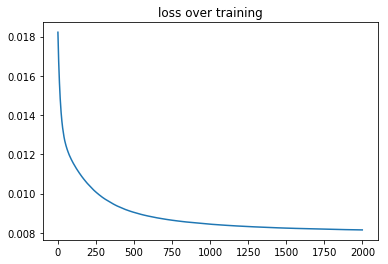

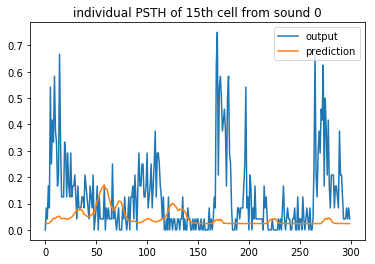

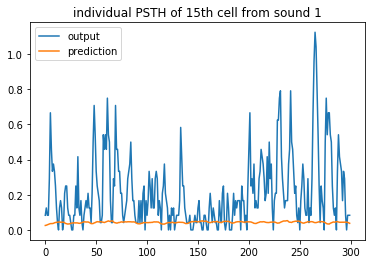

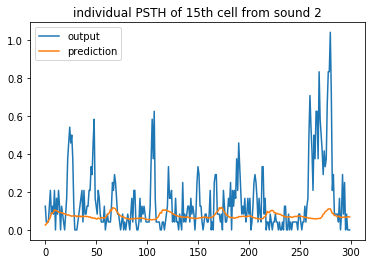

In [106]:
#Compare out and predicted
import random as rand
plt.plot(history.history['loss'])
plt.title('loss over training')
plt.figure

Predict_tests = True

if Predict_tests:
    for idx in range(3):
        example = idx
        plt.figure()
        plt.plot(Z[example,:,0])
        plt.plot(predicted[example,:,0])
        plt.title("individual PSTH of {}th cell from sound {}".format(cellidx,example))
        plt.legend(('output','prediction'))
        #prediction_error = sum(Z)
else :
    for idx in range(5):
        example = rand.randint(0,Y.shape[0]-1)    
        plt.figure()
        plt.plot(Y[example,:,0])
        plt.plot(predicted[example,:,0])
        plt.title("individual PSTH of {}th cell from sound {}".format(cellidx,example))
        plt.legend(('output','prediction'))

        

model.get_weights()[0]
#Y[0,:,0]

In [79]:
# SAVE MODEL

config = model.get_config()[0]
print(config)
save_name = config['class_name'] + '_'  + config['config']['activation'] + '_compiler-' + \
    loss + '-' + str(lr) + '_'+ '_ker-' + \
    str(config['config']['kernel_initializer']['config']['minval']) + '-' + \
    str(config['config']['kernel_initializer']['config']['maxval']) + '_' + \
    'epochs-' + str(epochs) + '_batch-' + str(batch_size) 
    
model.save('STRF_computation/models_trained/' + save_name)

{'class_name': 'Conv1D', 'config': {'name': 'conv1d_6', 'trainable': True, 'batch_input_shape': (None, 300, 18), 'dtype': 'float32', 'filters': 1, 'kernel_size': (10,), 'strides': (1,), 'padding': 'causal', 'dilation_rate': (1,), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomUniform', 'config': {'minval': 0, 'maxval': 0.5, 'seed': None}}, 'bias_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}


In [8]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
plt.imshow(np.transpose(X[43,:,:]),aspect='auto')

In [ ]:
plt.figure()
plt.subplot(3,1,1)
e

plt.subplot(3,1,2)
plt.imshow(h,origin='lower',aspect='auto')
plt.title("cell {0} raster".format(cellid))

plt.subplot(3,1,3)
plt.plot(m)
plt.title("cell {0} PSTH".format(cellid))


#!jupyter nbconvert --to script toolbox_fun.ipynb

In [ ]:
plt.subplot(3,1,3)
plt.plot(m)
plt.title("cell {0} PSTH".format(cellid))

